# XGBoost model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('seaborn')

# Data preparation

In [3]:
data = pd.read_csv('../../data/SamDysch_glucose_2-5-2022.csv', skiprows=[0])
data.index = pd.to_datetime(data['Device Timestamp'], format="%d-%m-%Y %H:%M")

/home/sdysch/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# drop non-historic glucose records
data = data[data['Record Type'] == 0]

# only keep bg
to_keep = [
    'Historic Glucose mmol/L',
]
data = data[to_keep]

data = data.rename(columns={'Historic Glucose mmol/L': 'reading'})

data.head()

,reading
Device Timestamp,
2019-12-09 19:04:00,6.8
2019-12-09 19:20:00,7.6
2019-12-09 19:35:00,7.7
2019-12-09 19:50:00,7.2
2019-12-09 20:05:00,5.8


In [5]:
# drop NaNs
data = data.dropna()

# Setup hypo threshold

In [6]:
HYPO_THRESHOLD = 3.9
data['is_hypo'] = (data['reading'] < HYPO_THRESHOLD).astype(int)

In [7]:
# adding some time variables
data['hour'] = data.index.hour
data['day'] = data.index.dayofweek
data['month'] = data.index.month

# OneHotEncode hours

In [8]:
data = pd.get_dummies(data, prefix='hour', columns=['hour'])
print(data.columns)

Index(['reading', 'is_hypo', 'day', 'month', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'],
      dtype='object')


# creating a lagged and rolling variables
* Was I hypo 15 mins ago? 30 mins ago? Etc
* Rolling average of last N readings
* Sign of gradient of last N readings:
    * I.e., is BG rising, falling, or stable?
    
## Lagged features

In [9]:
# create lags
# To ensure that we do not make a lag between periods of sensor non-usage, create a new df with the lagged indices & merge onto original data frame
def create_lag(df, lag):
    tolerance = 15 * lag
    freq = '15min'
    print(f'Creating lag of {tolerance} minutes')
    lagged_copy = df[['reading']].shift(lag, freq=freq)
    lagged_copy.rename(columns={'reading': f'lagged_reading_{lag}'}, inplace=True)
    
    merged = pd.merge_asof(df, lagged_copy, left_index=True, right_index=True, direction='backward', tolerance=pd.Timedelta(minutes=tolerance))
    # merged = pd.merge_asof(copy, lagged_copy, left_index=True, right_index=True, direction='backward')
    return merged

NLAGS = 8
for lag in range(1, NLAGS):
    data = create_lag(data, lag)

Creating lag of 15 minutes
Creating lag of 30 minutes
Creating lag of 45 minutes
Creating lag of 60 minutes
Creating lag of 75 minutes
Creating lag of 90 minutes
Creating lag of 105 minutes


In [10]:
# For ease of variable calculation, drop the nans
data = data.dropna()

In [11]:
# lagged hypo bools
for lag in range(1, NLAGS):
    data[f'is_lagged_hypo_{lag}'] = (data[f'lagged_reading_{lag}'] < HYPO_THRESHOLD).astype(int)

## Rolling features

In [12]:
# simple differences of lags - was reading higher, lower, or stable?
for lag in range(2, NLAGS):
    data[f'diff_{lag}'] = data['lagged_reading_1'] - data[f'lagged_reading_{lag}']

# gradients - how quick is BG changing?
interval = 15
for lag in range(2, NLAGS):
    data[f'rate_{lag}'] = data[f'diff_{lag}'] / (interval * lag)

## train, test, validation split

In [13]:
TRAIN_SPLIT = 0.65
VAL_SPLIT = 0.2
TEST_SPLIT = 0.15

In [14]:
itrain = int(TRAIN_SPLIT * len(data))
ival = int(VAL_SPLIT * len(data))
itest = int(TEST_SPLIT * len(data))

train_data = data.iloc[:itrain]
val_data = data.iloc[itrain:itrain + ival]
test_data = data.iloc[itrain + ival:]

# Variable selection

In [15]:
rates_and_diffs = [f'diff_{v}' for v in range(2, NLAGS)]
rates_and_diffs.extend([f'rate_{v}' for v in range(2, NLAGS)])

# to fairly compare with baseline, drop any historical variables with time delta < 45 mins
vars_to_drop = [
    'month',
    'day',
    'reading',
    'is_lagged_hypo_1',
    'is_lagged_hypo_2',
    'lagged_reading_1',
    'lagged_reading_2',
]
vars_to_drop.extend(rates_and_diffs)

train_data = train_data.drop(vars_to_drop, axis='columns')
val_data = val_data.drop(vars_to_drop, axis='columns')
test_data = test_data.drop(vars_to_drop, axis='columns')

print(train_data.columns)
print(val_data.columns)
print(test_data.columns)

Index(['is_hypo', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'lagged_reading_3', 'lagged_reading_4', 'lagged_reading_5',
       'lagged_reading_6', 'lagged_reading_7', 'is_lagged_hypo_3',
       'is_lagged_hypo_4', 'is_lagged_hypo_5', 'is_lagged_hypo_6',
       'is_lagged_hypo_7'],
      dtype='object')
Index(['is_hypo', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'lagged_reading_3', 'lagged_reading_4', 'lagged_reading_5',
       'lagged_reading_6', 'lagged_reading_7', 'is_lagged_hypo_3',
       'is_lagged_hypo_4', 'i

In [16]:
target = 'is_hypo'

X_train = train_data.drop([target], axis='columns')
y_train = train_data[target]

X_val = val_data.drop(target, axis='columns')
y_val = val_data[target]

X_test = test_data.drop(target, axis='columns')
y_test = test_data[target]

print(X_train.columns)

Index(['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'lagged_reading_3', 'lagged_reading_4', 'lagged_reading_5',
       'lagged_reading_6', 'lagged_reading_7', 'is_lagged_hypo_3',
       'is_lagged_hypo_4', 'is_lagged_hypo_5', 'is_lagged_hypo_6',
       'is_lagged_hypo_7'],
      dtype='object')


# class weights

In [17]:
# compute class weights to balance dataset
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train.to_numpy())
# print(class_weights)

weights_dict = {i: v for i, v in enumerate(class_weights)}
sample_weights = y_train.copy(deep=True)
sample_weights = sample_weights.map(weights_dict)
# print(sample_weights)

xgb_weight = float(y_train[y_train == 0].count()) / y_train[y_train == 1].count()
print(xgb_weight)

16.986577181208055


# model setup

In [18]:
# define model
from xgboost import XGBClassifier
model = XGBClassifier(
    #verbosity=2,
    n_estimators=300,
    # eta=0.3,
    eta=0.15,
    gamma=0,
    max_depth=6,
    reg_lambda=1,
    reg_alpha=0,
    subsample=0.5,
    scale_pos_weight=xgb_weight,
    objective='binary:logistic'   
)

In [19]:
# fit model
model.fit(
    X_train,
    y_train,
    eval_metric=['aucpr', 'logloss'],
    eval_set=[(X_train, y_train), (X_val, y_val)],
    early_stopping_rounds=15,
    #verbose=True
    verbose=False
)

/home/sdysch/.local/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/sdysch/.local/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.15,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.150000006, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

/tmp/ipykernel_4070/2300142190.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


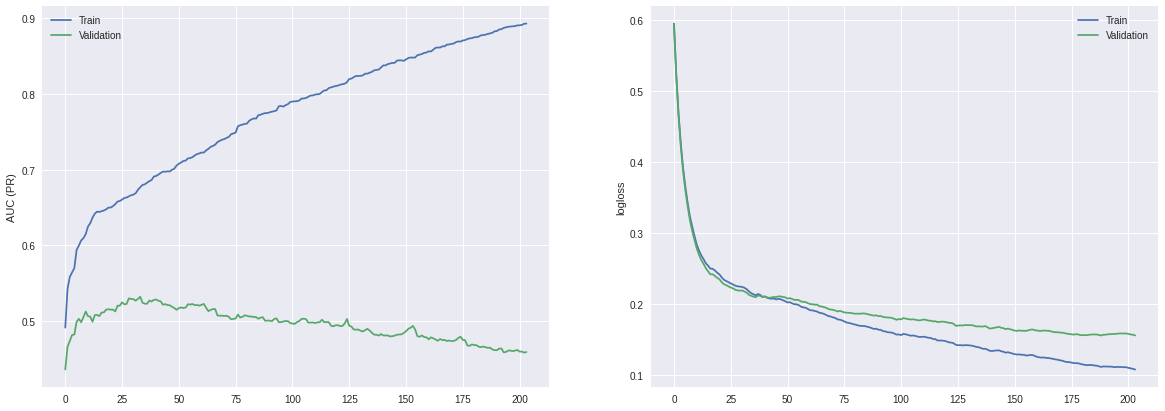

In [20]:
results = model.evals_result()

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(results['validation_0']['aucpr'], label='Train')
ax[0].plot(results['validation_1']['aucpr'], label='Validation')
ax[0].legend(loc='best')
ax[0].set_ylabel('AUC (PR)')

ax[1].plot(results['validation_0']['logloss'], label='Train')
ax[1].plot(results['validation_1']['logloss'], label='Validation')
ax[1].legend(loc='best')
ax[1].set_ylabel('logloss')


fig.show()

Accuracy: 0.9351657235246564
Precision: 0.2702078521939954
Recall: 0.5792079207920792
F1: 0.36850393700787404


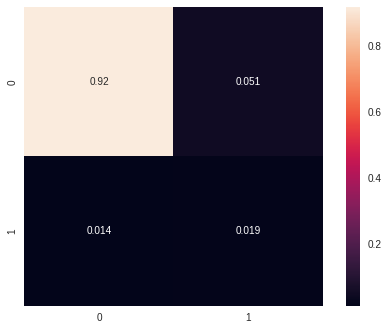

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1: {f1_score(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred, normalize='all')
sns.heatmap(cm, annot=True, square=True)

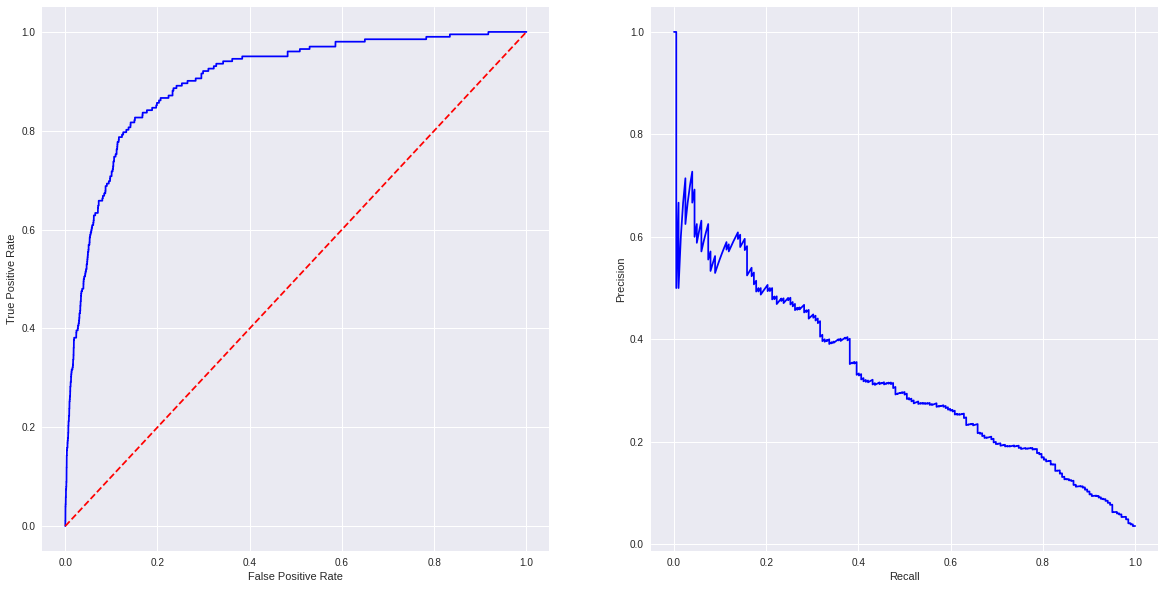

0.9029395167496025


In [22]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
y_pred_prob = model.predict_proba(X_test)[:, 1]

# fpr, tpr, _ = roc_curve(y_test, y_pred)
# precision, recall, _ = precision_recall_curve(y_test, y_pred)

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(fpr, tpr, 'b')
ax[0].plot([0, 1], [0, 1], 'r--')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')

ax[1].plot(recall, precision, 'b')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')

plt.show()
roc_auc = auc(fpr, tpr)
print(roc_auc)

In [23]:
# TODO, proper TimeSeries CV & hyperparameter tuning